In [61]:
from typing import Union # типизация
from tqdm import tqdm # прогресс-бар

import pandas as pd
import numpy as np
from scipy.stats import shapiro
import statsmodels.stats.power as TT

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power

In [2]:
df = pd.read_excel('data/gb_sem_8_hm.xlsx')
df

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [3]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.00
1,3,control,0.00
2,3,variant,0.00
3,4,variant,0.00
4,5,variant,0.00
...,...,...,...
7860,9996,control,0.00
7861,9996,variant,6.46
7862,9998,control,0.00
7863,10000,control,0.00


In [4]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [5]:
unique_ids = \
(df
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 #.['VARIANT_NAME'].value_counts()
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )

In [6]:
df_new = df[df.USER_ID.isin(unique_ids)].copy(deep=True)
df_new

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
5,6,variant,0.0
6,9,variant,0.0
...,...,...,...
7856,9990,variant,0.0
7857,9992,control,0.0
7858,9993,control,0.0
7859,9995,variant,0.0


In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4783 entries, 0 to 7862
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       4783 non-null   int64  
 1   VARIANT_NAME  4783 non-null   object 
 2   REVENUE       4783 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 149.5+ KB


In [8]:
control = df_new[df_new['VARIANT_NAME'] == 'control'].copy(deep=True)
treatment = df_new[df_new['VARIANT_NAME'] == 'variant'].copy(deep=True)

In [9]:
control.describe()

,USER_ID,REVENUE
count,2390.000000,2390.000000
mean,5020.881590,0.196887
std,2904.850992,4.172201
min,2.000000,0.000000
25%,2517.250000,0.000000
50%,5012.500000,0.000000
75%,7616.000000,0.000000
max,9998.000000,196.010000


In [10]:
treatment.describe()

,USER_ID,REVENUE
count,2393.000000,2393.000000
mean,4967.943168,0.074935
std,2892.745368,0.858207
min,4.000000,0.000000
25%,2435.000000,0.000000
50%,4955.000000,0.000000
75%,7379.000000,0.000000
max,9995.000000,23.040000


# Применение статистических критериев

In [13]:
def continious_result(control: pd.DataFrame,
                      treatment: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Статистика по выборкам
    size = control.loc[:, column].shape[0] # размер столбца контроль, отфильтрованного из датафрема
    
    control_mean = control.loc[:, column].mean()  # среднее значение столбца, отфильтрованного из датафрема
    treatment_mean = treatment.loc[:, column].mean()
    
    control_std = control.loc[:, column].std(ddof=1)
    treatment_std = treatment.loc[:, column].std(ddof=1)
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = control.loc[:, column].sample(n=size, replace=True).values
        treatment_sample = treatment.loc[:, column].sample(n=size, replace=True).values
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size, _ = effectsize_smd(mean1=treatment_mean, sd1=treatment_std, nobs1=size,
                                    mean2=control_mean, sd2=control_std, nobs2=size)
    power = tt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [14]:
def proportion_result(control: pd.DataFrame,
                      treatment: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Вероятность событий
    size = control.loc[:, column].shape[0]
    prop_control = control.loc[:, column].sum() / size
    prop_treatment = treatment.loc[:, column].sum() / size
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = stats.bernoulli.rvs(p=prop_control, size=size)
        treatment_sample = stats.bernoulli.rvs(p=prop_treatment, size=size)
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size = proportion.proportion_effectsize(prop_control, prop_treatment)
    
    power = zt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [16]:
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.00
1,3,control,0.00
2,3,variant,0.00
3,4,variant,0.00
4,5,variant,0.00
...,...,...,...
7860,9996,control,0.00
7861,9996,variant,6.46
7862,9998,control,0.00
7863,10000,control,0.00


In [18]:
import plotly.express as px
fig = px.histogram(df_new,
                   x='REVENUE',
                   color = 'VARIANT_NAME',
                   title='avg_site_visits_distribution',
                   marginal = 'box',
                   nbins = 100,
                   barmode='overlay')

fig.show()

In [19]:
# Очевдино, данные не имеют нормального распределения.

In [27]:
df_not_null = df[df['REVENUE']>0]

(array([49., 12.,  6.,  4.,  4.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.000000e-02, 3.939800e+00, 7.859600e+00, 1.177940e+01,
        1.569920e+01, 1.961900e+01, 2.353880e+01, 2.745860e+01,
        3.137840e+01, 3.529820e+01, 3.921800e+01, 4.313780e+01,
        4.705760e+01, 5.097740e+01, 5.489720e+01, 5.881700e+01,
        6.273680e+01, 6.665660e+01, 7.057640e+01, 7.449620e+01,
        7.841600e+01, 8.233580e+01, 8.625560e+01, 9.017540e+01,
        9.409520e+01, 9.801500e+01, 1.019348e+02, 1.058546e+02,
        1.097744e+02, 1.136942e+02, 1.176140e+02, 1.215338e+02,
        1.254536e+02, 1.293734e+02, 1.332932e+02, 1.372130e+02,
        1.411328e+02, 1.450526e+02, 1.489724e+02, 1.528922e+02,
        1.568120e+02, 1.607318e+02, 1.646516e+02, 1.685714e+02,
        1.72

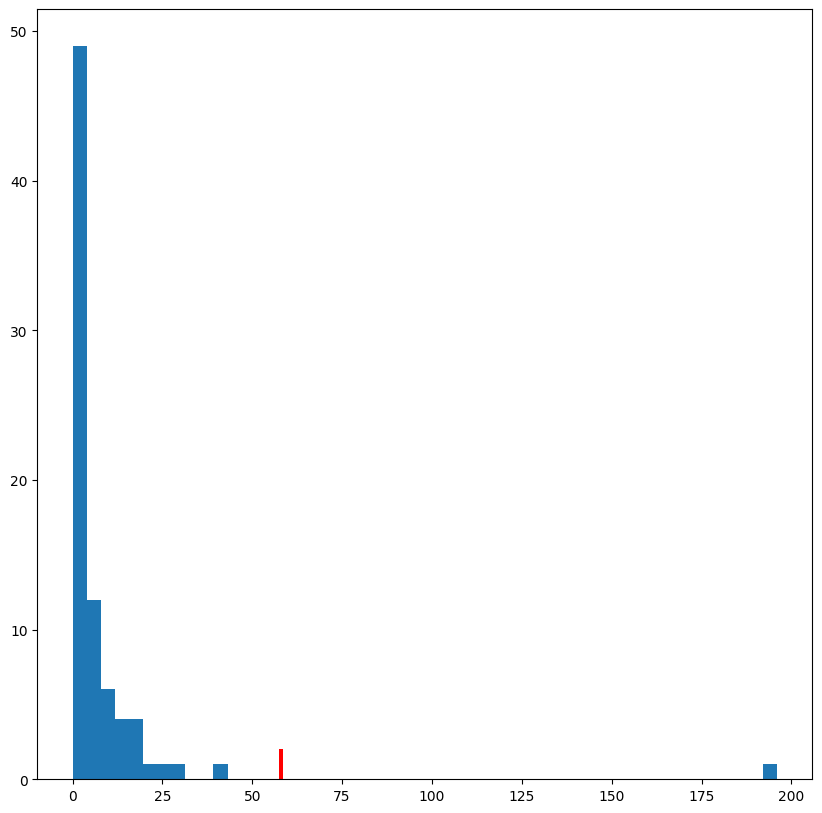

In [28]:
plt.figure(figsize=(10, 10))
control_visit_all = df_not_null['REVENUE'][df_not_null['VARIANT_NAME'] == 'variant']
test_visit_all =df_not_null['REVENUE'][df_not_null['VARIANT_NAME'] == 'control']


plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all,  bins=50)


In [32]:
stats.ttest_ind(control.REVENUE,treatment.REVENUE,equal_var = False )

Ttest_indResult(statistic=1.3996978409515475, pvalue=0.16172355638776942)

# p-value достаточно большое, чтобы не отклонять нулевую гипотезу о том, что среднее значения равны.

# Непараметрический тест Манна-Уитни

In [34]:
df.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3931.0,0.163572,3.385721,0.0,0.0,0.0,0.0,196.01
variant,3934.0,0.089342,1.484566,0.0,0.0,0.0,0.0,58.63


In [44]:
mw_stats = stats.mannwhitneyu(x=df[(df['VARIANT_NAME'] == 'variant')]['REVENUE'].values,
                                                  y=df[(df['VARIANT_NAME'] == 'control')]['REVENUE'].values)
mw_stats

MannwhitneyuResult(statistic=7714034.5, pvalue=0.4459080979612927)

In [45]:
# p-value достаточно большое, чтобы не отклонять нулевую гипотезу о том, выборки различны не

In [48]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning:

p-value may not be accurate for N > 5000.



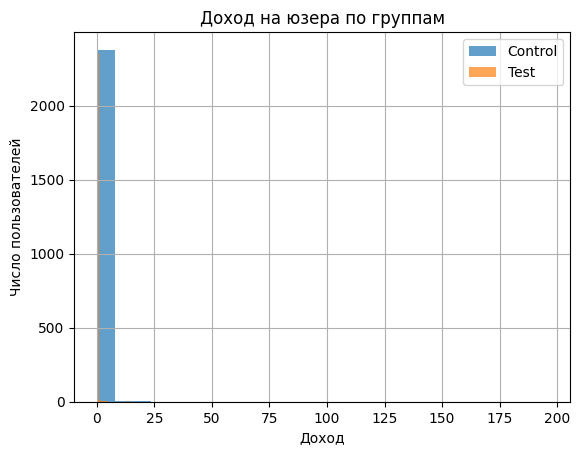

In [50]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
treatment.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

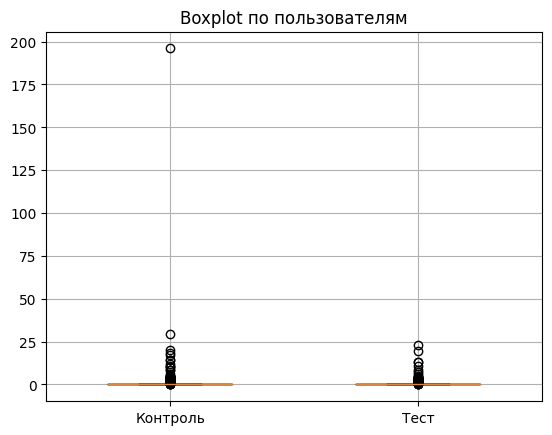

In [51]:
plt.boxplot([control.REVENUE,treatment.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [53]:
C_mean = control.REVENUE.values.mean()

T_mean = treatment.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = treatment.REVENUE.values.std()

In [55]:
print(len(control.REVENUE.values), len(treatment.REVENUE.values))

2390 2393


In [56]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [64]:
n = len(control.REVENUE.values)

In [58]:
ef =float((T_mean-C_mean)/ S) 

In [65]:
alpha = 0.05

# perform power analysis
analysis = TT.TTestIndPower()
result = analysis.solve_power(ef, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.28803096229144043